In [1]:
import pandas as pd
import numpy as np
from data_master import DataMaster
from utils import func
from scipy.stats import norm
master = DataMaster()
from utils.func import center
from quantstats.stats import sharpe
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
market_data = pd.read_parquet('data/US/mkt_data.pq')
balance_sheet = pd.read_parquet('data/US/balance_sheets.pq')
GICS = pd.read_parquet('data/US/GICS.pq')
P = pd.read_parquet('data/US/universe_table.pq')
R = market_data['close'].unstack().reindex_like(P).pct_change()
market_data.dropna().sample(5)

,,datetime,open,high,low,close,adj_close,volume,MktCap
Date,Ticker,,,,,,,,
2018-04-27,ECL,2018-04-27,145.93,147.0900,144.65,146.71,139.0675,1196853,4.299154e+10
2015-05-01,ZBRA,2015-05-01,91.66,93.1076,91.26,92.50,92.5000,359077,4.665417e+09
2009-10-13,TSS,2009-10-13,16.31,16.4400,16.19,16.40,16.4000,960900,3.194800e+09
2015-12-31,CZR,2015-12-31,11.06,11.2000,10.78,11.00,11.0000,332738,5.190758e+08
2018-08-28,TJX,2018-08-28,107.60,107.7800,106.55,107.61,50.6633,4490312,1.360358e+11


In [8]:
metrics = ta.slope(df_ticker['close'],length=5)
metrics

Date
2013-02-01      NaN
2013-02-04      NaN
2013-02-05      NaN
2013-02-06      NaN
2013-02-07      NaN
              ...  
2023-03-30    0.582
2023-03-31    0.452
2023-04-03    0.390
2023-04-04    0.406
2023-04-05    0.998
Name: SLOPE_5, Length: 2562, dtype: float64

In [76]:

def slope_price( close, length=None, as_angle=None, to_degrees=None, vertical=None, offset=None, **kwargs):
    """Indicator: Slope"""
    # Validate arguments
    length = int(length) if length and length > 0 else 1
    as_angle = True if isinstance(as_angle, bool) else False
    to_degrees = True if isinstance(to_degrees, bool) else False
    offset   = int(offset) if offset else 0

    if close is None: return

    # Calculate Result
    slope = close.diff(length) / length
    if as_angle:
        slope = slope.apply(np.arctan)
        if to_degrees:
            slope *= 180 / np.pi

    # Offset
    if offset != 0:
        slope = slope.shift(offset)

    # Handle fills
    if "fillna" in kwargs:
        slope.fillna(kwargs["fillna"], inplace=True)
    if "fill_method" in kwargs:
        slope.fillna(method=kwargs["fill_method"], inplace=True)


    return slope

In [83]:
import pandas_ta as ta
from tqdm import tqdm
results ={}
for ticker in tqdm(market_data.index.get_level_values(1).unique()):
    df_ticker = market_data.xs(ticker,level=1)
    try :
        metrics = slope_price(df_ticker['close'].ewm(alpha=0.5).mean(),length=5)
        results[ticker] = metrics

    except :
        print(ticker)


100%|██████████| 866/866 [00:04<00:00, 206.02it/s]


C:\Users\marti\AppData\Local\Temp\ipykernel_26076\1339208527.py:7: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  signal = signal[P].groupby(GICS['gicgrp'],axis=1).apply(center)


Sharpe      1.6
Turnover    0.6
biais       2.6
dtype: float64

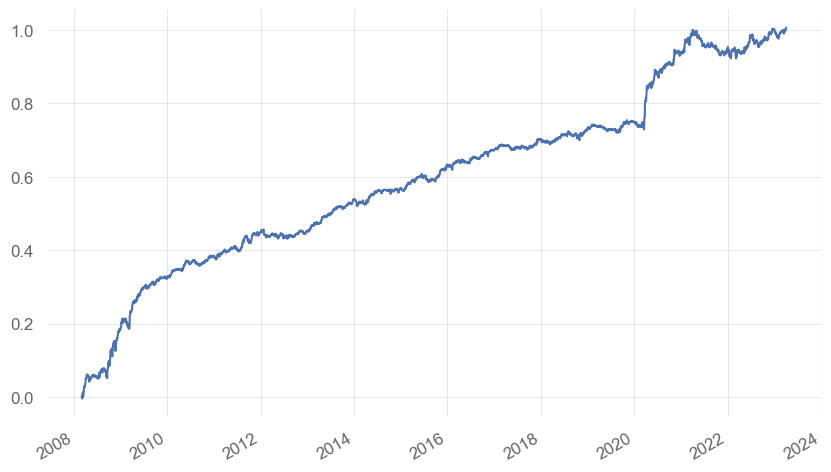

In [95]:
signal = pd.concat(results,axis=1).reindex_like(P).ffill()
signal = signal[P].abs().rolling(21).max() * np.sign(signal[P])
signal = signal[P].rank(axis=1,pct=True,ascending=False).clip(0.01,0.99).apply(norm.ppf)

signal[signal.abs()<0.5] = None

signal = signal[P].groupby(GICS['gicgrp'],axis=1).apply(center)
signal = signal[P].div(signal[P].abs().sum(1),0)

PNL = (signal[P].shift()*R).sum(1).replace({0:np.nan}).dropna()
sr = sharpe(PNL)
turnover = signal.fillna(0).diff().abs().sum(1).mean()
PNL.cumsum().plot()
pd.Series({'Sharpe':sr,'Turnover':turnover,'biais':PNL.mean()*1e4}).round(1)

<Axes: >

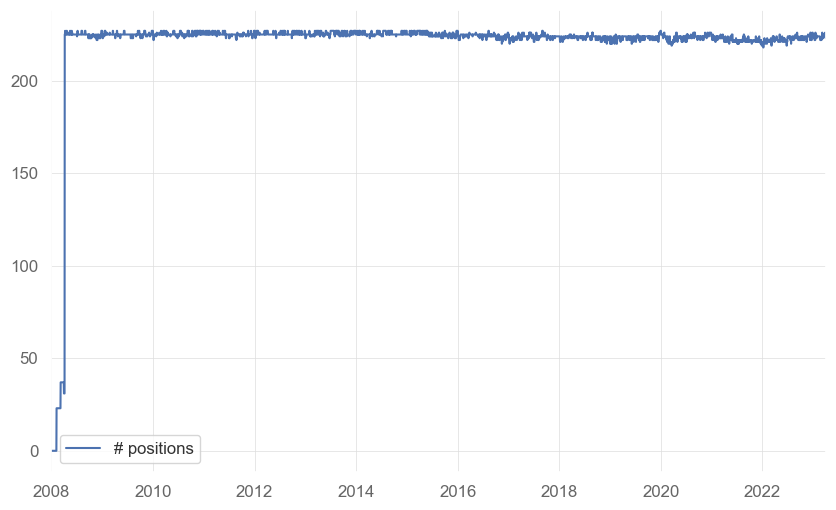

In [74]:
signal.count(1).plot(label ='# positions',legend=True)

<Axes: >

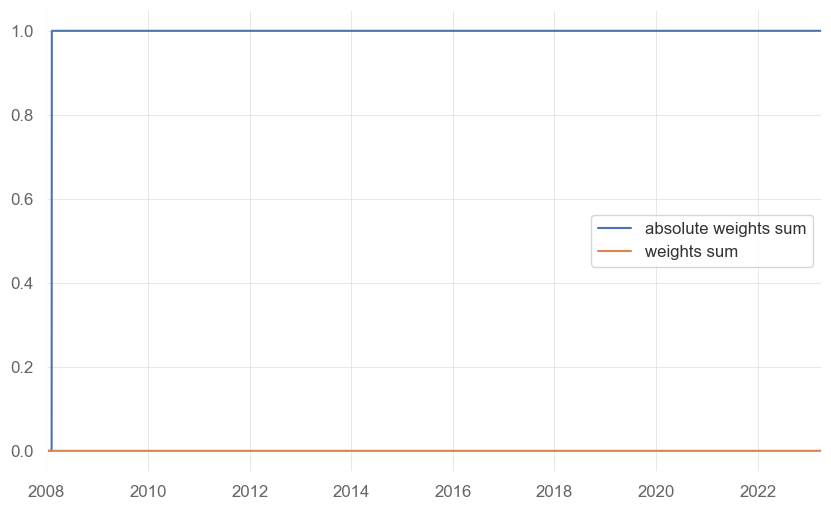

In [75]:
signal.abs().sum(1).plot(label = 'absolute weights sum',legend=True)
signal.sum(1).plot(label='weights sum',legend=True)